In [2]:
from numba import njit,vectorize

In [3]:
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import numpy as np
import random

In [4]:
sbn.set()

# 1. An Introduction to Stochastic Simulation of Chemical Kinetics

Let us consider a system with $N$ chemical species $\{S_{1},S_{2},\dots,S_{N}\}$ with $X_{i}$ number of molecules of species $S_{i}$. From a classical mechanics viewpoint we assume the chemical kinetics as a deterministic system, then given a initial point we can describe how the distribution of species will be in any point on the future. Such behavior is ruled by Reaction-Rate equations, a set of coupled, first-order, ordinary diferential equations of the forms:
$$
\displaystyle\frac{dX_{i}}{dt} = f_{i}\left(X_{1},X_{2},\dots,X_{N}\right)
$$
Where each $f_{i}$ is inferred from a specific reaction. 

It is remarkable to note that for system of test-tube size or larger then RRE approximation works quites well because molecular effects when larger populations can be considered as an average of some distribution and then descreteness and stochastisity are negligible. When the system is smaller Stochasithc Chemical Kinetics attemps to describe the evolution of populations over time of a well-stirred chemical reacting systems confined to a constant volume $\Omega$ and in thermal (but not chemical) equilibrium at some constante temperature $T$.

Stochasitc Simulation Algorithm (SSA) is a Monte-Carlo precedure for numerically generating time trajectories of molecular populations in _exact_ accordance with the Chemical Master Equation (CME). It is possible to summarize the SSA as following (cfr. [2]):
1. Initialize the time $t=t_{0}$ and the system's state $\mathbf{x} = \mathbf{x_{0}}$
2. With the system in state $\mathbf{x}$ and time $t$, evaluate all the *propensity functions* $a_{j}(\mathbf{x})$ and their sum $a_{0}(\mathbf{x}) = \displaystyle\sum_{j'=1}^{M} a_{j'}(\mathbf{x})$
1. Generate values for $\tau$ and $j$ some Monte Carlo produre as direct method (so called direct simulation too) where there are generated two random variables $r_{1},\, r_{2}$ from a $U(0,1)$ en then $\tau = \displaystyle\frac{1}{a_{0}(\mathbf{x})}\ln{\left(\frac{1}{r_{1}}\right)}$ and $j = \min\left\{ j' \displaystyle|\sum_{k=1}^{j'} a_{k}(\mathbf{x}) > a_{0}(\mathbf{x}) \right\}$
1. Effect the next reaction by replacing $t \leftarrow t + r$ and $\mathbf{x} \leftarrow \mathbf{x} + \mathbf{\nu_{j}}$
1. Record $(\mathbf{x},t)$. Return to Step 2 or else end the simulation. 

# 2. Some examples

## 2.1 A first example: A simple reaction (cfr. [1])

Let us consider the simple reaction:
$$
S \xrightarrow{\;\; C \;\; } \emptyset
$$
The RRE equation is then
$$
\displaystyle\frac{dX}{dt} = -cX
$$
If we assume a initial condition $X(t=t_{0}) = x_{0}$ then we have the following general solution:
$$
X(t) = x_{0} e^{-ct}
$$

On the other hand, the propensity funtion is $a(x)=cx$ and the state change vector is simply $\nu = -1$

Let us suppose $X(0)=100$ and $c=1$ and let us develop the SSA with direct method. 

In [5]:
def SSA(x,t,a,v,t_max,seed = 42):
    """
    A toy version of the SSA described in the notebook
    
    Params
    ---------
    x : array_like
        A vector of states vectors, if len(x)>1 then is going to be used x[-1]
    t : array_like
        A vecttor of timesteps, t0 = t[-1]
    a : func
        The vectorial function form of all propensity functions
    v : array_like
        The state change vector or matrix
    t_max : float
        The condition time to stop
    seed : int
        Seed to secure reproducibility
        
    Returns
    ----------
    x : array_like
        x.shape = (m,n) where m is number if reactions and n the number of
        molecular species
        The whole system vector-population after a R_{i} in a time t_{i}
    t : array_like
        The time steps at which each reaction occurs
    """
    if seed!=None:
        np.random.seed(seed)
    idx = np.arange(len(v))
    while True:
        x0,t0 = x[-1],t[-1]
        
        if np.sum(a(x0),axis=0).dtype == 'int64':
            a_vector = np.asarray([np.sum(a(x0),axis=0)])
        else:
            a_vector = a(x0)

        a_0 = np.sum(a_vector)
        if a_0 == 0: #first stop condition
            break
            
        # Tau dist prob of generating function is a_{0}*exp(-tau*a_{0}) therefore the following is more stable than the later tau-generator
        tau = np.random.exponential(scale=1/a_0)
        # the dist prob of generating function of j is a_{j}/a_{0}, a point probability so the following is more stable than the later j-generator
        j = random.choices(idx,weights=a_vector/a_0)[0]
                
        t = np.append(t,t0+tau)
        x = np.append(x,[x0+v[j]],axis=0)
        #print(t0+tau,a_vector,a_0,j)
        if t0+tau>=t_max:
            break
        
    return x,t

In [9]:
a = lambda x: 1*x
v = [-1]

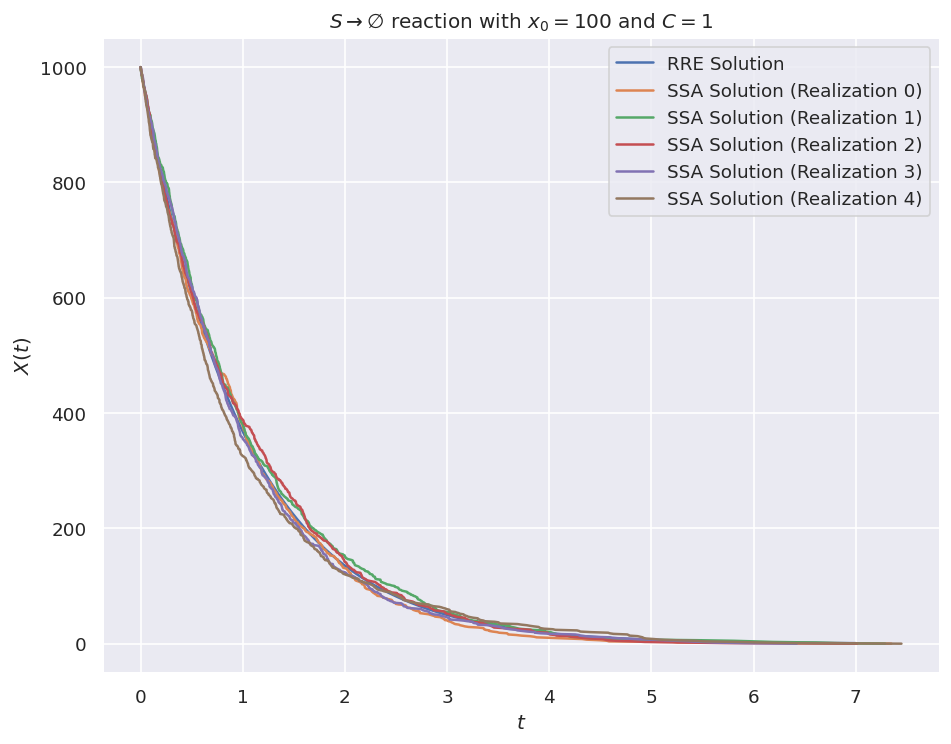

In [10]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(9,7))
ax.plot(np.linspace(0,7,1000),1000*np.exp(-1*np.linspace(0,7,1000)),label='RRE Solution')
for i in range(5):
    x,t = SSA(x=[1000],t=[0],a=a,v=v,t_max=7,seed=42+i)
    ax.plot(t,x,label='SSA Solution (Realization {})'.format(i))

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X(t)$')
ax.set_title(r'$S \rightarrow \emptyset$ reaction with $x_{0}=100$ and $C = 1$')

ax.legend()

plt.show()

Let us note that the RRE solution behave as the mean of many repetitions of SSA solution

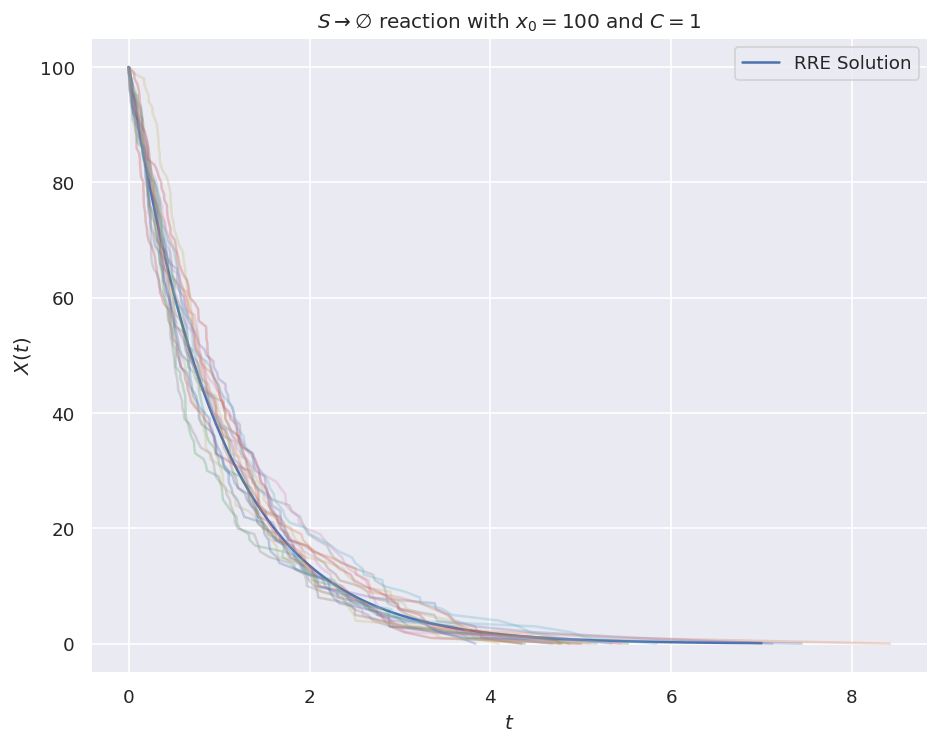

In [18]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(9,7))
ax.plot(np.linspace(0,7,1000),100*np.exp(-1*np.linspace(0,7,1000)),label='RRE Solution')
for i in range(20):
    x,t = SSA(x=[100],t=[0],a=a,v=v,t_max=7,seed=None)
    ax.plot(t,x,alpha=0.3)

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X(t)$')
ax.set_title(r'$S \rightarrow \emptyset$ reaction with $x_{0}=100$ and $C = 1$')

ax.legend()

plt.show()

## 2.2 Second example, a more complicated reaction (cfr. [2])

A most complicated reaction is as following
$$
\begin{eqnarray}
&\bar{X}+ Y& \xrightarrow{\;\; C_{1} \;\; } 2Y \\
&2Y& \xrightarrow{\;\; C_{2} \;\; } Z
\end{eqnarray}
$$
Where $\bar{X}$ denotes that the molecular population  is constant over time.

In the context of RSE we obtain for Y
$$
\displaystyle\frac{dY}{dt} = c_1 [\bar{X}] [Y] - 2 c_{2} [Y]^2
$$

But in the context of SSA we got a state change vector $\mathbf{\nu} = [1,-1]$ and $a_{1}(Y) = c_{1}[\bar{X}][Y(t)]$, $a_{2}(Y) =\displaystyle\frac{c_{2}}{2}[Y(t)]([Y(t)]-1)$. 

In [19]:
def R(Y,k,c):
    return np.asarray([Y*k,0.5*Y*(Y-1)*c])

To reproduce the results we use $k=c_{1}[\bar{X}] = 5$ and $c_{2}=0.005$ with two conditions $y_{0}=10$ and $y_{0}=3000$

In [24]:
a = lambda y : R(y,k=5,c=0.005)
v = [+1,-2]

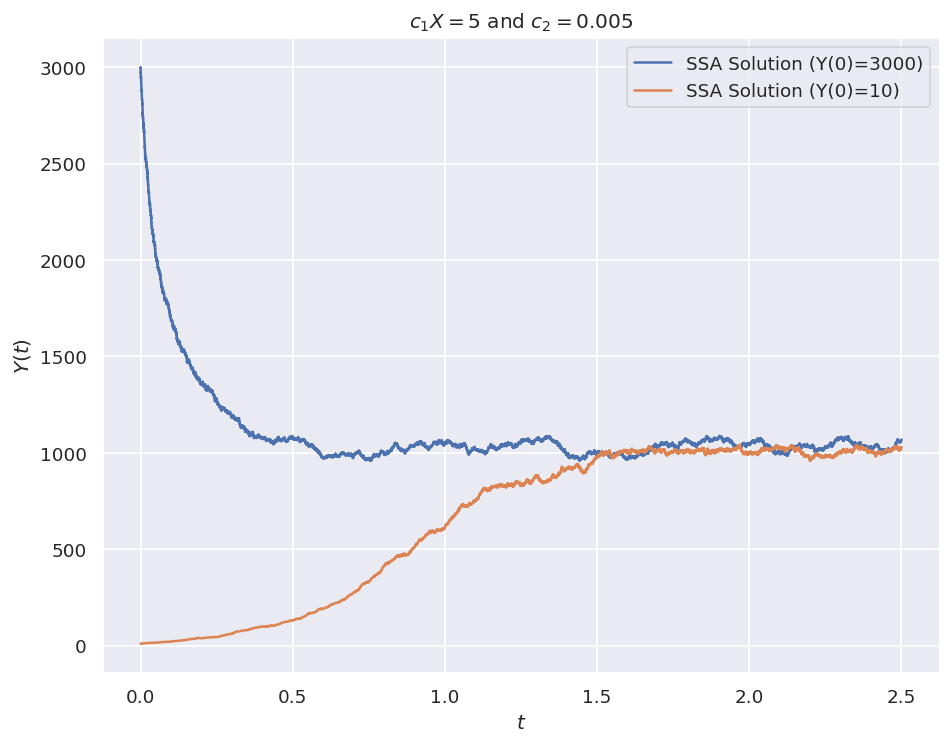

In [25]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(9,7))

for i in [3000,10]:
    x,t = SSA(x=[i],t=[0],a=a,v=v,t_max=2.5,seed=None)
    ax.plot(t,x,label='SSA Solution (Y(0)={})'.format(i))

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$Y(t)$')
ax.set_title(r'$c_{1}X = 5$ and $c_{2}=0.005$')

ax.legend()

plt.show()

Again, to reproduce results we use $k=c_{1}[\bar{X}] = 5$ and $c_{2}=0.00125$ with two conditions $y_{0}=40$ and $y_{0}=12000$

In [26]:
a = lambda y : R(y,k=5,c=0.00125)
v = [+1,-2]

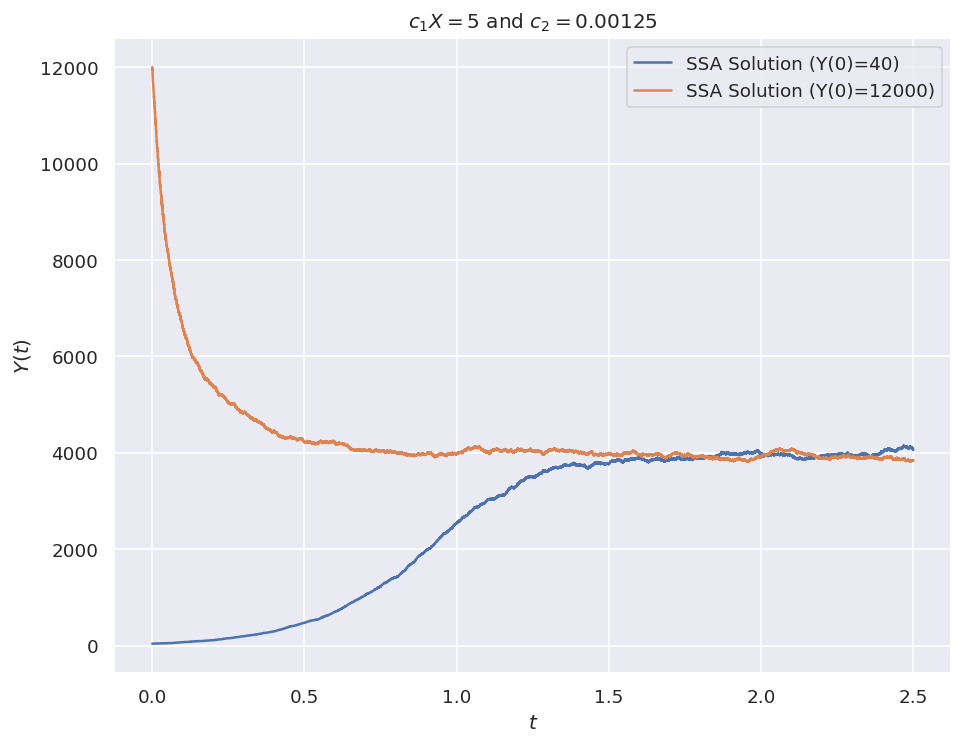

In [27]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(9,7))

for i in [40,12000]:
    x,t = SSA(x=[i],t=[0],a=a,v=v,t_max=2.5)
    ax.plot(t,x,label='SSA Solution (Y(0)={})'.format(i))

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$Y(t)$')
ax.set_title(r'$c_{1}X = 5$ and $c_{2}=0.00125$')

ax.legend()

plt.show()

## 2.3 The Lotka Reactions (cfr. [2])

The so called _Lotka Reaction_ is as following
$$
\begin{eqnarray}
&\bar{X} + Y_{1}& \xrightarrow{\;\; C_{1} \;\; } 2Y_{1} \\
&Y_{1} + Y_{2}& \xrightarrow{\;\; C_{2} \;\; } 2Y_{2} \\
&Y_{2}& \xrightarrow{\;\; C_{3} \;\; } Z
\end{eqnarray}
$$

Where $\bar{X}$ denotes that the molecular population  is constant over time.

In the context of RSE we get
$$
\begin{eqnarray}
\displaystyle\frac{dY_{1}}{dt} &=& c_1 [\bar{X}] [Y_{1}] - c_{2} [Y_{1}][Y_{2}] \\
\displaystyle\frac{dY_{2}}{dt} &=& c_{2} [Y_{1}][Y_{2}] - c_{3}[Y_{2}]
\end{eqnarray}
$$

And we get the following set of propensity equations:
$$
\begin{eqnarray}
a_{1}(\mathbf{Y}) &=& c_1 [\bar{X}][Y_{1}] = k[Y_{1}]\\
a_{2}(\mathbf{Y}) &=& c_2 [Y_{2}][Y_{1}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{2}]
\end{eqnarray}
$$
And the asociated state-change vectors are:
$$
\begin{eqnarray}
\nu_{1} &=& [1,0] \\
\nu_{2} &=& [-1,-1] \\
\nu_{3} &=& [0,-1]
\end{eqnarray}
$$

In [38]:
def R(Y,k,c2,c3):
    return np.asarray([k*Y[0],c2*Y[0]*Y[1], c3*Y[1]])

To reproduce results we're going to use $k=c_{1}[\bar{X}] = 10$, $c_{2}=0.01$ and $c_{3}=10$ with initial condition $\mathbf{Y_{0}}=[1000,1000]$

In [39]:
a = lambda y : R(y,k=10,c2=0.01,c3=10)
v = np.asarray([
    [1,0],
    [-1,1],
    [0,-1]
])

**NOTE**: for the next simulation the seed = 42

In [55]:
x,t = SSA(x=np.asarray([[1000,1000]]),t=[0],a=a,v=v,t_max=30)

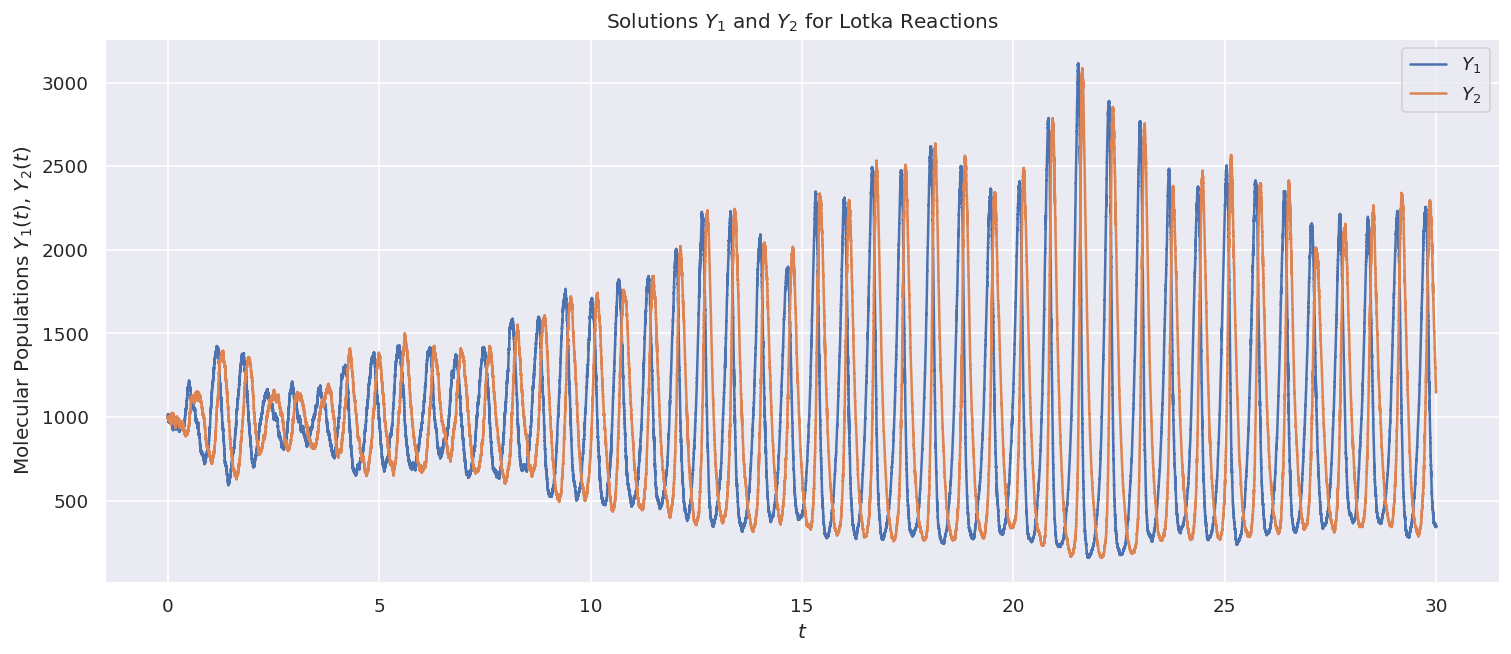

In [63]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(15,6))

ax.plot(t,x[:,0],label=r'$Y_{1}$ ')
ax.plot(t,x[:,1],label=r'$Y_{2}$')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Molecular Populations $Y_{1}(t)$, $Y_{2}(t)$')
ax.set_title(r'Solutions $Y_{1}$ and $Y_{2}$ for Lotka Reactions')

ax.legend()

plt.show()

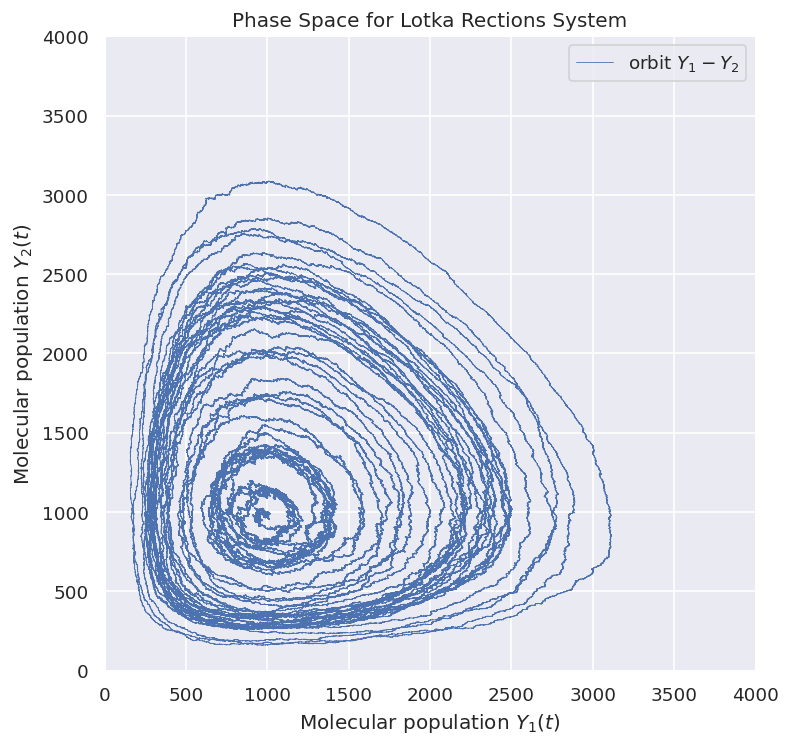

In [67]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(7,7))


ax.plot(x[:,0],x[:,1],label='orbit $Y_{1}-Y_{2}$',lw=0.5)

ax.set_xlabel(r'Molecular population $Y_{1}(t)$')
ax.set_ylabel(r'Molecular population $Y_{2}(t)$')
ax.set_title(r'Phase Space for Lotka Rections System')

ax.set_ylim(0,4000)
ax.set_xlim(0,4000)

ax.legend()

plt.show()

For get the results we run the simulation in the time interval $0\le t <30$ and were realized $898,067$ reactions. 

Let us make another realization of same experiment but with another **seed = 4242**

In [69]:
x,t = SSA(x=np.asarray([[1000,1000]]),t=[0],a=a,v=v,t_max=30,seed=4242)

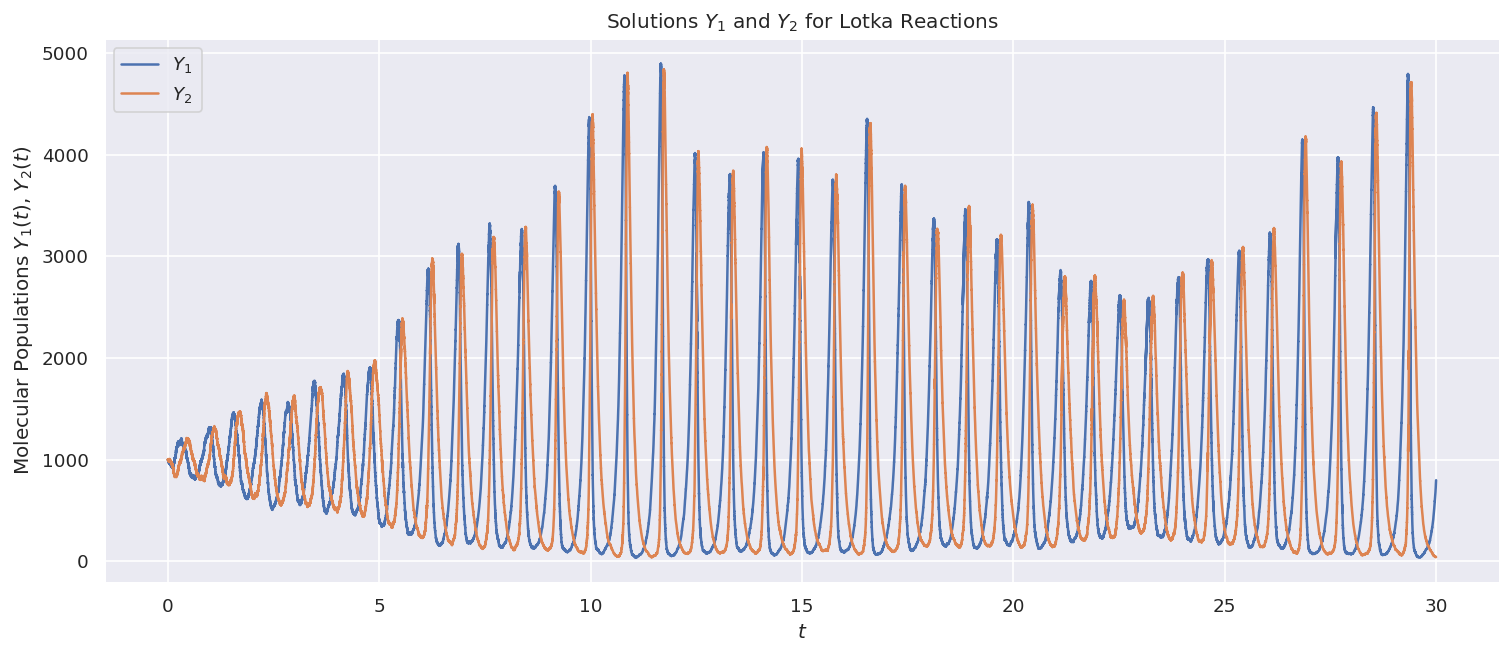

In [70]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(15,6))

ax.plot(t,x[:,0],label=r'$Y_{1}$ ')
ax.plot(t,x[:,1],label=r'$Y_{2}$')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Molecular Populations $Y_{1}(t)$, $Y_{2}(t)$')
ax.set_title(r'Solutions $Y_{1}$ and $Y_{2}$ for Lotka Reactions')

ax.legend()

plt.show()

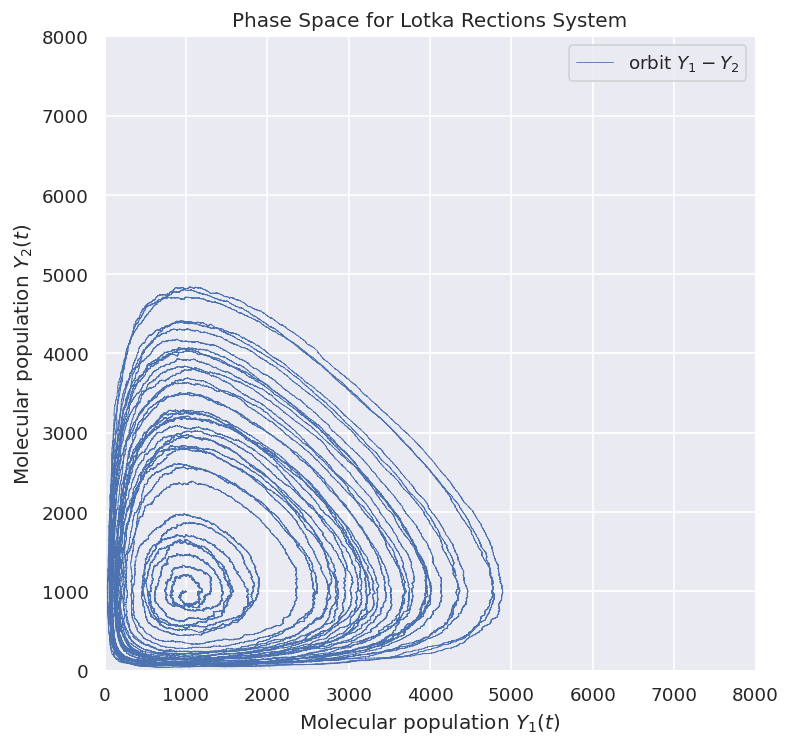

In [72]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(7,7))


ax.plot(x[:,0],x[:,1],label='orbit $Y_{1}-Y_{2}$',lw=0.5)

ax.set_xlabel(r'Molecular population $Y_{1}(t)$')
ax.set_ylabel(r'Molecular population $Y_{2}(t)$')
ax.set_title(r'Phase Space for Lotka Rections System')

ax.set_ylim(0,8000)
ax.set_xlim(0,8000)

ax.legend()

plt.show()

Changing the seed clearly does not alter the dynamic instead of alters the size of perturbations: how do we stochastically evolve in time and how state-change vectors are chosen.

The simulation ran the time interval $0\le t <30$ and achived $893,614$ reactions. 

Now, lets consider the Lotka Reactions again but witout a reservoir $\bar{X}$:
$$
\begin{eqnarray}
&X + Y_{1}& \xrightarrow{\;\; C_{1} \;\; } 2Y_{1} \\
&Y_{1} + Y_{2}& \xrightarrow{\;\; C_{2} \;\; } 2Y_{2} \\
&Y_{2}& \xrightarrow{\;\; C_{3} \;\; } Z
\end{eqnarray}
$$
Where the molecular population $X$ decays over each reaction

The set of equations is almost the same as the one presented before except for X:
$$
\begin{eqnarray}
a_{1}(\mathbf{Y}) &=& c_1 [X][Y_{1}] \\
a_{2}(\mathbf{Y}) &=& c_2 [Y_{2}][Y_{1}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{2}]
\end{eqnarray}
$$
And the asociated state-change vectors are:
$$
\begin{eqnarray}
\nu_{1} &=& [-1,1,0] \\
\nu_{2} &=& [0,-1,1] \\
\nu_{3} &=& [0,0,-1]
\end{eqnarray}
$$

In [5]:
def R(Y,c1,c2,c3):
    return np.asarray([c1*Y[0]*Y[1],c2*Y[1]*Y[2], c3*Y[2]])

To reproduce results we're going to use $c_{1}= 0.0001$, $c_{2}=0.01$ and $c_{3}=10$ with initial condition $\mathbf{Y_{0}}=[1\times 10^{5},1000,1000]$

In [7]:
a = lambda y : R(y,c1=0.0001,c2=0.01,c3=10)
v = np.asarray([
    [-1,1,0],
    [0,-1,1],
    [0,0,-1]
])

**NOTE**: for the next simulation the default seed = 42

In [8]:
x,t = SSA(x=np.asarray([[1e5,1000,1000]]),t=[0],a=a,v=v,t_max=30)

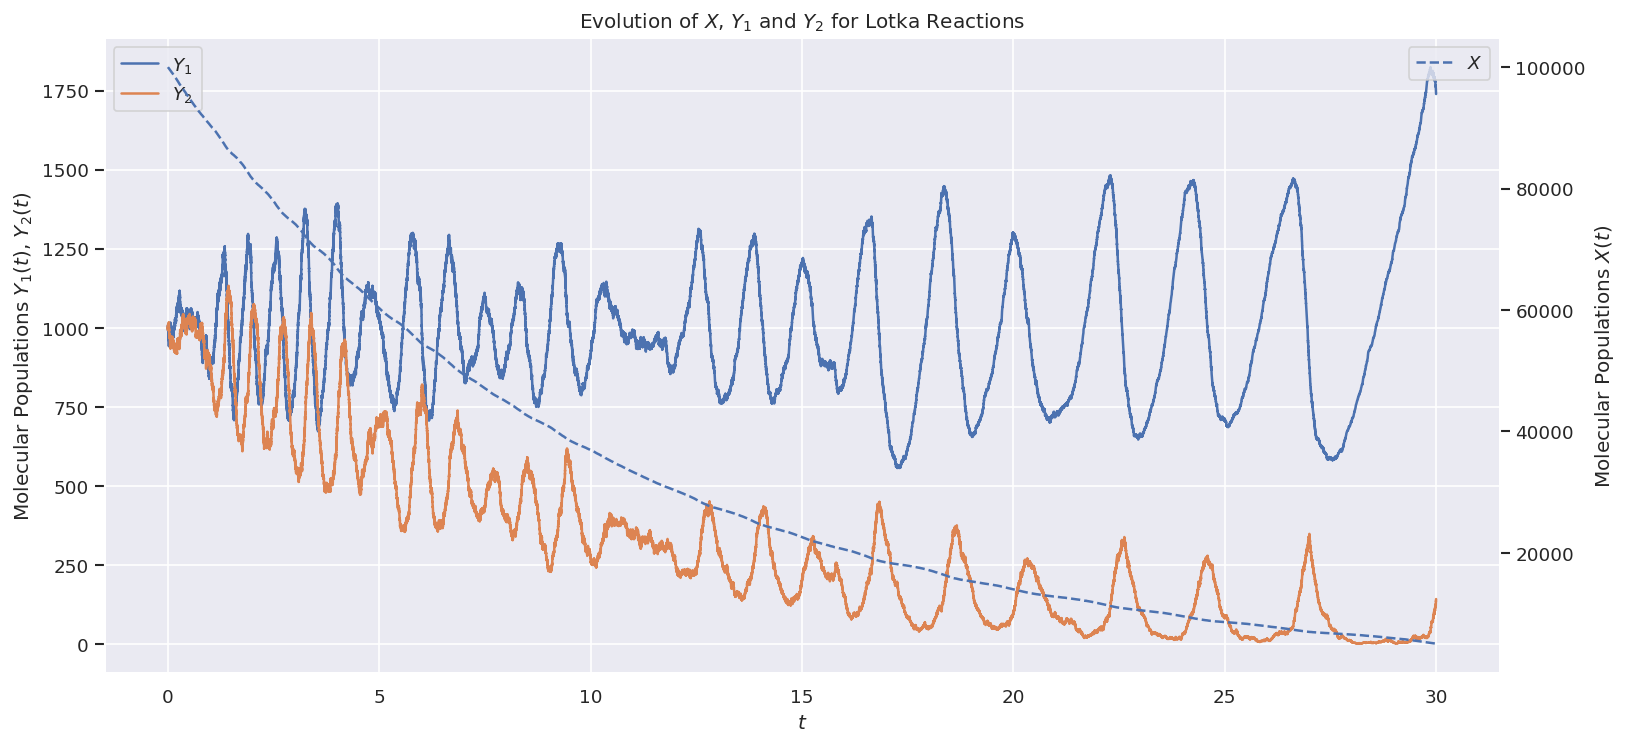

In [19]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(15,7))

ax.plot(t,x[:,1],label=r'$Y_{1}$ ')
ax.plot(t,x[:,2],label=r'$Y_{2}$')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Molecular Populations $Y_{1}(t)$, $Y_{2}(t)$')
ax.set_title(r'Evolution of $X$, $Y_{1}$ and $Y_{2}$ for Lotka Reactions')

ax1 = ax.twinx()
ax1.plot(t,x[:,0],label=r'$X$',ls='--')
ax1.set_ylabel(r'Molecular Populations $X(t)$')

ax.legend()
ax1.legend()

ax1.grid(False)
plt.show()

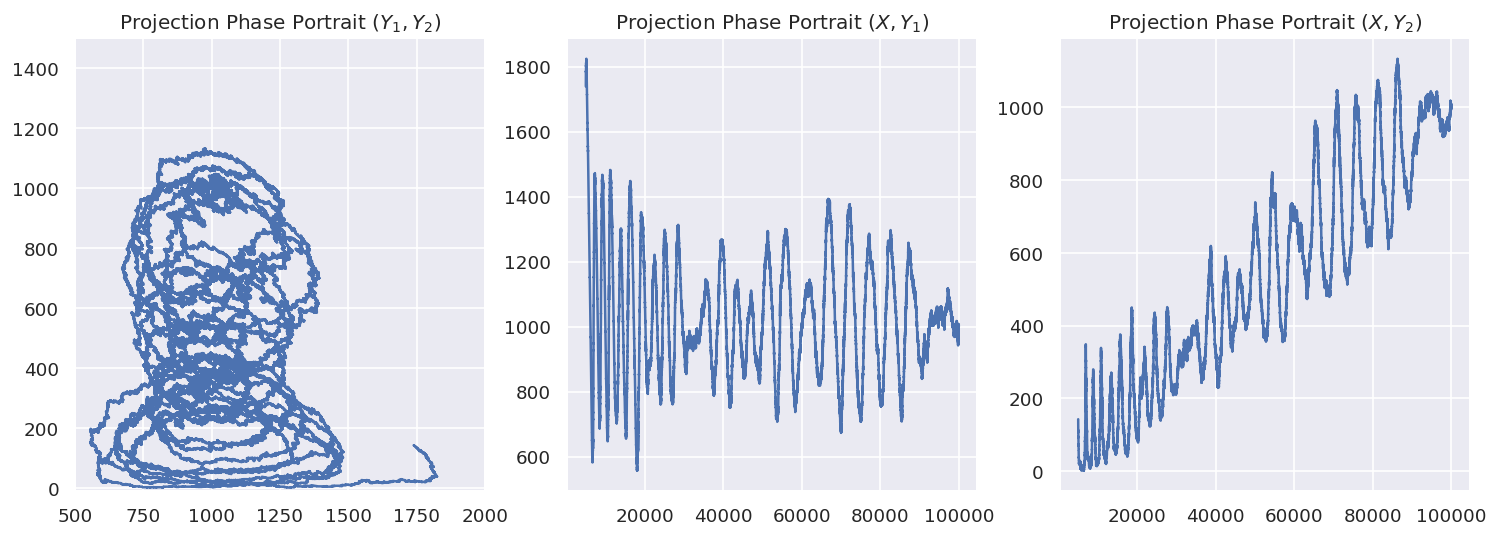

In [35]:
fig,ax = plt.subplots(1,3,dpi=120,figsize=(15,5))

ax[0].plot(x[:,1],x[:,2])
ax[0].set_ylim(-10,1500)
ax[0].set_xlim(500,2000)
ax[0].set_title(r'Projection Phase Portrait $(Y_{1},Y_{2})$')

ax[1].plot(x[:,0],x[:,1])
ax[1].set_title(r'Projection Phase Portrait $(X,Y_{1})$')


ax[2].plot(x[:,0],x[:,2])
ax[2].set_title(r'Projection Phase Portrait $(X,Y_{2})$')

plt.show()

The simulation ran the time interval $0≤t<30$ and achived $284,269$ reactions. Lets note that when $t\approx 28.1$ the molecular population $Y_{2}$ got almost extinct.

Let us make another realization of same experiment but this time with **seed = 4242**

In [45]:
x,t = SSA(x=np.asarray([[1e5,1000,1000]]),t=[0],a=a,v=v,t_max=30,seed=4242)

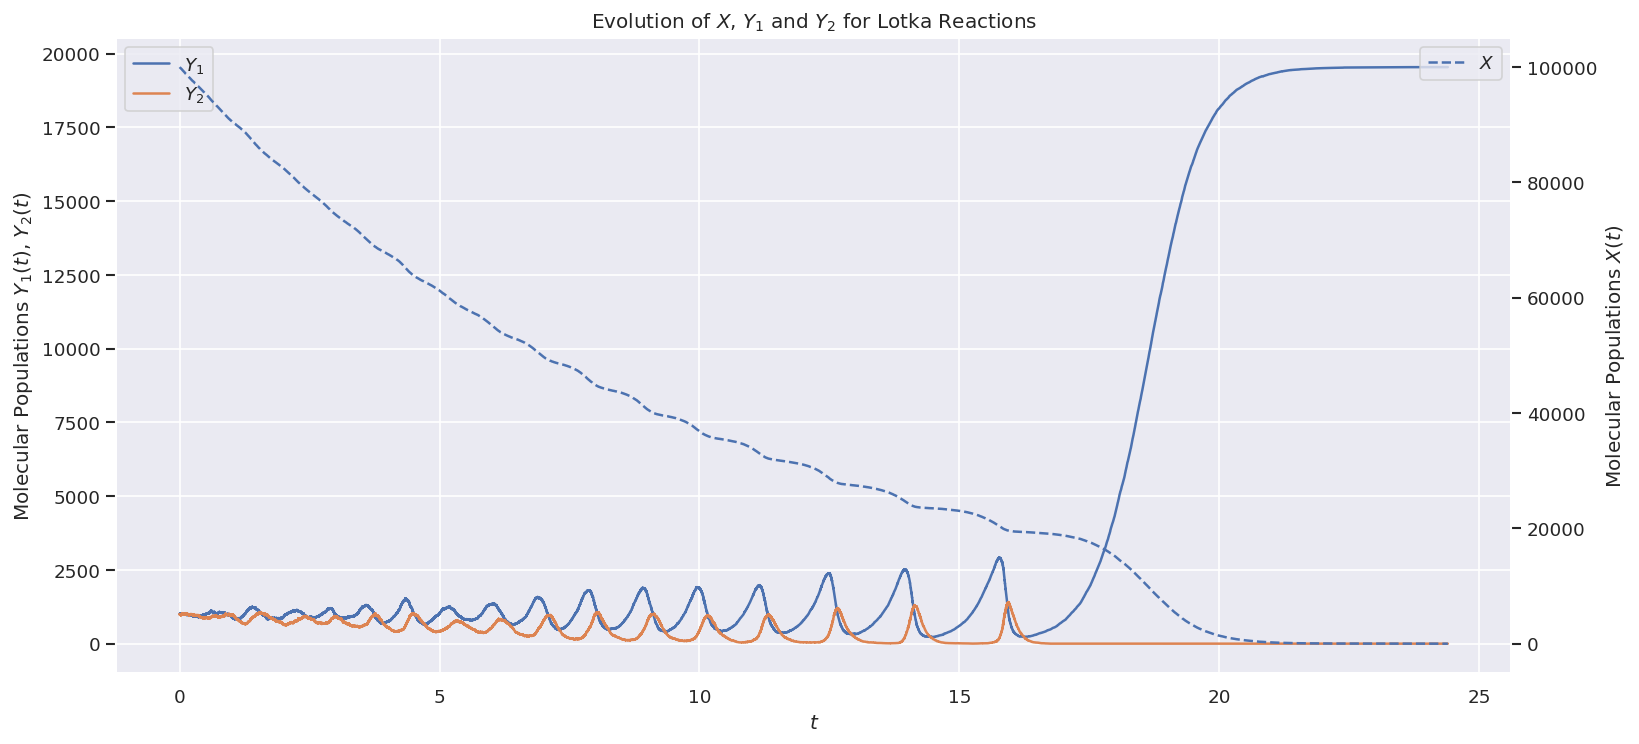

In [46]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(15,7))

ax.plot(t,x[:,1],label=r'$Y_{1}$ ')
ax.plot(t,x[:,2],label=r'$Y_{2}$')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Molecular Populations $Y_{1}(t)$, $Y_{2}(t)$')
ax.set_title(r'Evolution of $X$, $Y_{1}$ and $Y_{2}$ for Lotka Reactions')

ax1 = ax.twinx()
ax1.plot(t,x[:,0],label=r'$X$',ls='--')
ax1.set_ylabel(r'Molecular Populations $X(t)$')

ax.legend()
ax1.legend()

ax1.grid(False)
plt.show()

In [63]:
fig,ax = plt.subplots(1,3,dpi=120,figsize=(15,5))

ax[0].plot(x[:,1],x[:,2])
ax[0].set_ylim(-100,1500)
ax[0].set_xlim(0,3500)
ax[0].set_title(r'Projection Phase Portrait $(Y_{1},Y_{2})$')

ax[1].plot(x[:,0],x[:,1])
ax[1].set_title(r'Projection Phase Portrait $(X,Y_{1})$')


ax[2].plot(x[:,0],x[:,2])
ax[2].set_title(r'Projection Phase Portrait $(X,Y_{2})$')

plt.show()

The simulation ran the time interval $0≤t<30$ and achived $263,921$ reactions. Lets note that when $t\approx 16.8$ the molecular population $Y_{2}$ got extinct, when $t\approx 24.3$ the molecular population $X$ got exinct and around same time $Y_{1}$ got to steady-state $Y_{1}^s=19,540$. The existance of a s-state given the dynamics and the initial conditions is expected because $R_{1}$ has a greater probablity to occur in initial steps therefore $Y_{1}$ becomes a dominant population.

Let us allow to molecular population $Y_{1}$ naturally decays which lead us to the following system:
$$
\begin{eqnarray}
&X + Y_{1}& \xrightarrow{\;\; C_{1} \;\; } 2Y_{1} \\
&Y_{1} + Y_{2}& \xrightarrow{\;\; C_{2} \;\; } 2Y_{2} \\
&Y_{2}& \xrightarrow{\;\; C_{3} \;\; } Z \\
&Y_{1}& \xrightarrow{\;\; C_{4} \;\; } Z
\end{eqnarray}
$$
In a biological sense this will allows preys to die of natural causes. 

The new set of equations:
$$
\begin{eqnarray}
a_{1}(\mathbf{Y}) &=& c_1 [X][Y_{1}] \\
a_{2}(\mathbf{Y}) &=& c_2 [Y_{2}][Y_{1}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{2}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{1}]
\end{eqnarray}
$$
And the asociated state-change vectors are:
$$
\begin{eqnarray}
\nu_{1} &=& [-1,1,0] \\
\nu_{2} &=& [0,-1,1] \\
\nu_{3} &=& [0,0,-1] \\
\nu_{4} &=& [0,-1,0]
\end{eqnarray}
$$

We consider to use $c_{1}= 0.0002$, $c_{2}=0.01$ and $c_{3}=c_{4}=10$ with initial condition $\mathbf{Y_{0}}=[10^{5},10^{3},10^{3}]$

In [71]:
def R(Y,c1,c2,c3,c4):
    return np.asarray([c1*Y[0]*Y[1],c2*Y[1]*Y[2],c3*Y[2],c4*Y[1]])

In [75]:
a = lambda y : R(y,c1=0.0002,c2=0.01,c3=10,c4=10)
v = np.asarray([
    [-1,1,0],
    [0,-1,1],
    [0,0,-1],
    [0,-1,0]
])

**NOTE**: for the next simulation the default seed = 42

In [76]:
x,t = SSA(x=np.asarray([[1e5,1e3,1e3]]),t=[0],a=a,v=v,t_max=30)

In [77]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(15,7))

ax.plot(t,x[:,1],label=r'$Y_{1}$ ')
ax.plot(t,x[:,2],label=r'$Y_{2}$')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Molecular Populations $Y_{1}(t)$, $Y_{2}(t)$')
ax.set_title(r'Evolution of $X$, $Y_{1}$ and $Y_{2}$ for Lotka Reactions')

ax1 = ax.twinx()
ax1.plot(t,x[:,0],label=r'$X$',ls='--')
ax1.set_ylabel(r'Molecular Populations $X(t)$')

ax.legend()
ax1.legend()

ax1.grid(False)
plt.show()

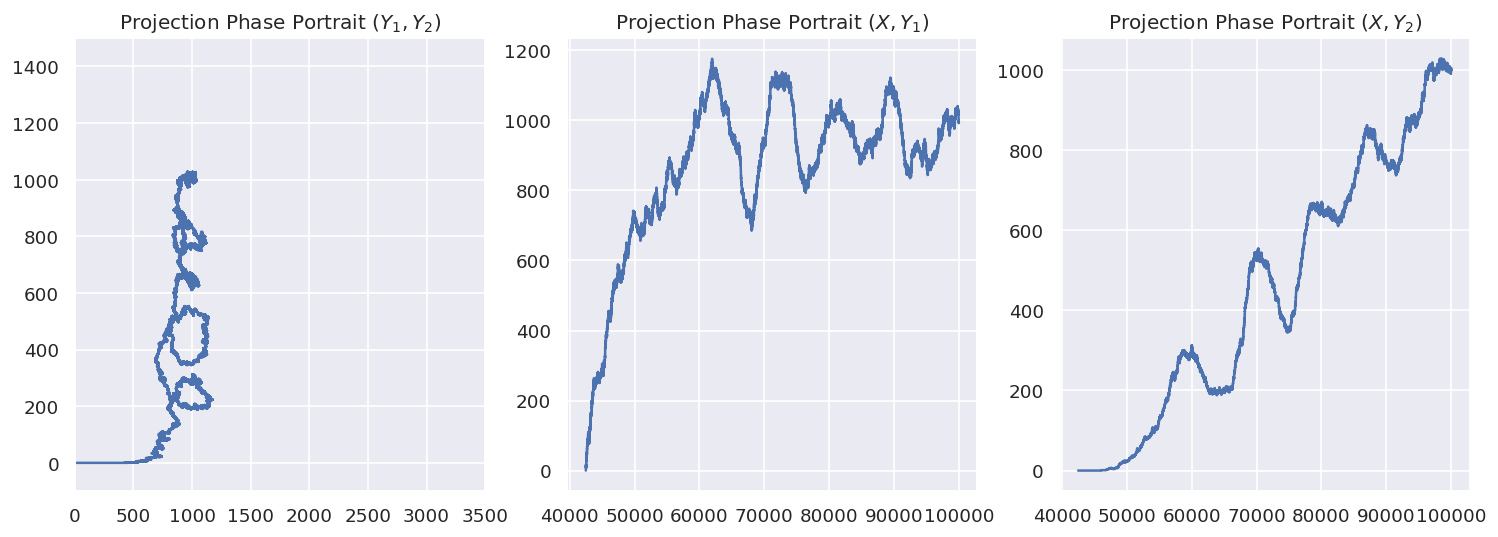

In [78]:
fig,ax = plt.subplots(1,3,dpi=120,figsize=(15,5))

ax[0].plot(x[:,1],x[:,2])
ax[0].set_ylim(-100,1500)
ax[0].set_xlim(0,3500)
ax[0].set_title(r'Projection Phase Portrait $(Y_{1},Y_{2})$')

ax[1].plot(x[:,0],x[:,1])
ax[1].set_title(r'Projection Phase Portrait $(X,Y_{1})$')


ax[2].plot(x[:,0],x[:,2])
ax[2].set_title(r'Projection Phase Portrait $(X,Y_{2})$')

plt.show()

The simulation was able to run in time interval $0≤t<30$ but get stopped by $t\approx 7.9$ and achived $132,930$ reactions. Lets note that when $t\approx 4.5$ the molecular population $Y_{2}$ got extinct, when $t\approx 7.9$ molecular population $Y_{1}$ got extinted but $X$ was not, it was $X = 42,477$. The only admissible state, and even alredy expected because of the system dynamics, was the populations $Y_{1}$ and $Y_{2}$ to extinct. 

To conclude the study of Lokta Reactions like systems let us consider again that $X\equiv\bar{X}$:
$$
\begin{eqnarray}
&\bar{X} + Y_{1}& \xrightarrow{\;\; C_{1} \;\; } 2Y_{1} \\
&Y_{1} + Y_{2}& \xrightarrow{\;\; C_{2} \;\; } 2Y_{2} \\
&Y_{2}& \xrightarrow{\;\; C_{3} \;\; } Z \\
&Y_{1}& \xrightarrow{\;\; C_{4} \;\; } Z
\end{eqnarray}
$$

The new set of equations:
$$
\begin{eqnarray}
a_{1}(\mathbf{Y}) &=& c_1 [\bar{X}][Y_{1}] = k[Y_{1}] \\
a_{2}(\mathbf{Y}) &=& c_2 [Y_{2}][Y_{1}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{2}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{1}]
\end{eqnarray}
$$
And the asociated state-change vectors are:
$$
\begin{eqnarray}
\nu_{1} &=& [1,0] \\
\nu_{2} &=& [-1,1] \\
\nu_{3} &=& [0,-1] \\
\nu_{4} &=& [-1,0]
\end{eqnarray}
$$

We can reduce the dimension given that $\bar{x}$ does not decay and $k=20=(1\times10^5)(0.0002)$

In [89]:
def R(Y,k,c2,c3,c4):
    return np.asarray([k*Y[0],c2*Y[0]*Y[1],c3*Y[1],c4*Y[0]])

In [91]:
a = lambda y : R(y,k=20,c2=0.01,c3=10,c4=10)
v = np.asarray([
    [1,0],
    [-1,1],
    [0,-1],
    [-1,0]
])

In [92]:
x,t = SSA(x=np.asarray([[1e3,1e3]]),t=[0],a=a,v=v,t_max=30)

In [93]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(15,7))

ax.plot(t,x[:,0],label=r'$Y_{1}$ ')
ax.plot(t,x[:,1],label=r'$Y_{2}$')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Molecular Populations $Y_{1}(t)$, $Y_{2}(t)$')
ax.set_title(r'Evolution of $X$, $Y_{1}$ and $Y_{2}$ for Lotka Reactions')

ax.legend()

plt.show()

In [95]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(7,7))


ax.plot(x[:,0],x[:,1],label='orbit $Y_{1}-Y_{2}$',lw=0.5)

ax.set_xlabel(r'Molecular population $Y_{1}(t)$')
ax.set_ylabel(r'Molecular population $Y_{2}(t)$')
ax.set_title(r'Phase Space for Lotka Rections System')

ax.set_ylim(0,5000)
ax.set_xlim(0,5000)

ax.legend()

plt.show()

For this run time evolves in $0\le t<30$ and we achive $1,496,111$ reactions. In this time interval we were not able to visualize but the future of the species is to extinct, we can observe how the amplitud of oscilations as time evolve gets higer and eventually lead to extition first of $Y_{2}$ and afterwards $Y_{1}$.

Last but not least lest do as an excersice to check up the distribution of the differences of time. If all was done correctly then the distribution should be exponential.

In [145]:
dt = np.asarray([t[i]-t[i-1] for i in range(1,len(t))])
dt = dt/np.max(dt)
dt_cumsum = np.asarray([1-i for i in dt])
dt_cumsum.sort()
x_range = np.arange(len(dt_cumsum[0::3]))

In [146]:
fig,ax = plt.subplots(1,2,dpi=120,figsize=(10,4))
sbn.distplot(a=dt,kde=False,ax=ax[0])
sbn.lineplot(x=x_range,y=dt_cumsum[0::3],ax=ax[1])

ax[0].set_title('Histogram of differences between time-steps')
ax[1].set_title('Computed Cumulative Distribution (Sampled)')
plt.show()

In fact, the time between reactions is distributed as exponential. 

## 2.4 The Brusselator (cfr. [2])

_The Brusselator_ is a model set of chemical reaction which exhibits an attractor limit cycle as well in Van Der Pol Oscillator:
$$
\begin{eqnarray}
&\bar{X}_{1} & \xrightarrow{\;\; C_{1} \;\; } Y_{1} \\
&\bar{X}_{2} + Y_{1}& \xrightarrow{\;\; C_{2} \;\; } Y_{2} + Z_{1} \\
&2Y_{1}+Y_{2}& \xrightarrow{\;\; C_{3} \;\; } 3 Y_{1} \\
&Y_{1}& \xrightarrow{\;\; C_{4} \;\; } Z
\end{eqnarray}
$$

The set of equations is as follows:
$$
\begin{eqnarray}
a_{1}(\mathbf{Y}) &=& c_1 [\bar{X}_{1}] = k_{1} \\
a_{2}(\mathbf{Y}) &=& c_2 [\bar{X}_{2}][Y_{1}] = k_{2}[Y_{1}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{2}][Y_{1}]\displaystyle\frac{([Y_{1}]-1)}{2} \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{1}]
\end{eqnarray}
$$
And the asociated state-change vectors are:
$$
\begin{eqnarray}
\nu_{1} &=& [1,0] \\
\nu_{2} &=& [-1,1] \\
\nu_{3} &=& [1,-1] \\
\nu_{4} &=& [-1,0]
\end{eqnarray}
$$

To reproduce results we're going to use $k_{1}= 5000$, $k_{2}=50$, $c_{3}=0.00005$ and $c_{4}=5$ with initial condition $\mathbf{Y_{0}}=[1000,2000]$

In [5]:
def R(Y,c1,k2,c3,c4):
    return np.asarray([k1,k2*Y[0],c3*Y[1]*Y[0]*0.5*(Y[0]-1),c4*Y[0]])

In [6]:
a = lambda y : R(y,k1=5000,k2=50,c3=0.00005,c4=5)
v = np.asarray([
    [1,0],
    [-1,1],
    [1,-1],
    [-1,0]
])

In [14]:
x,t = SSA(x=np.asarray([[1000,2000]]),t=[0],a=a,v=v,t_max=14)

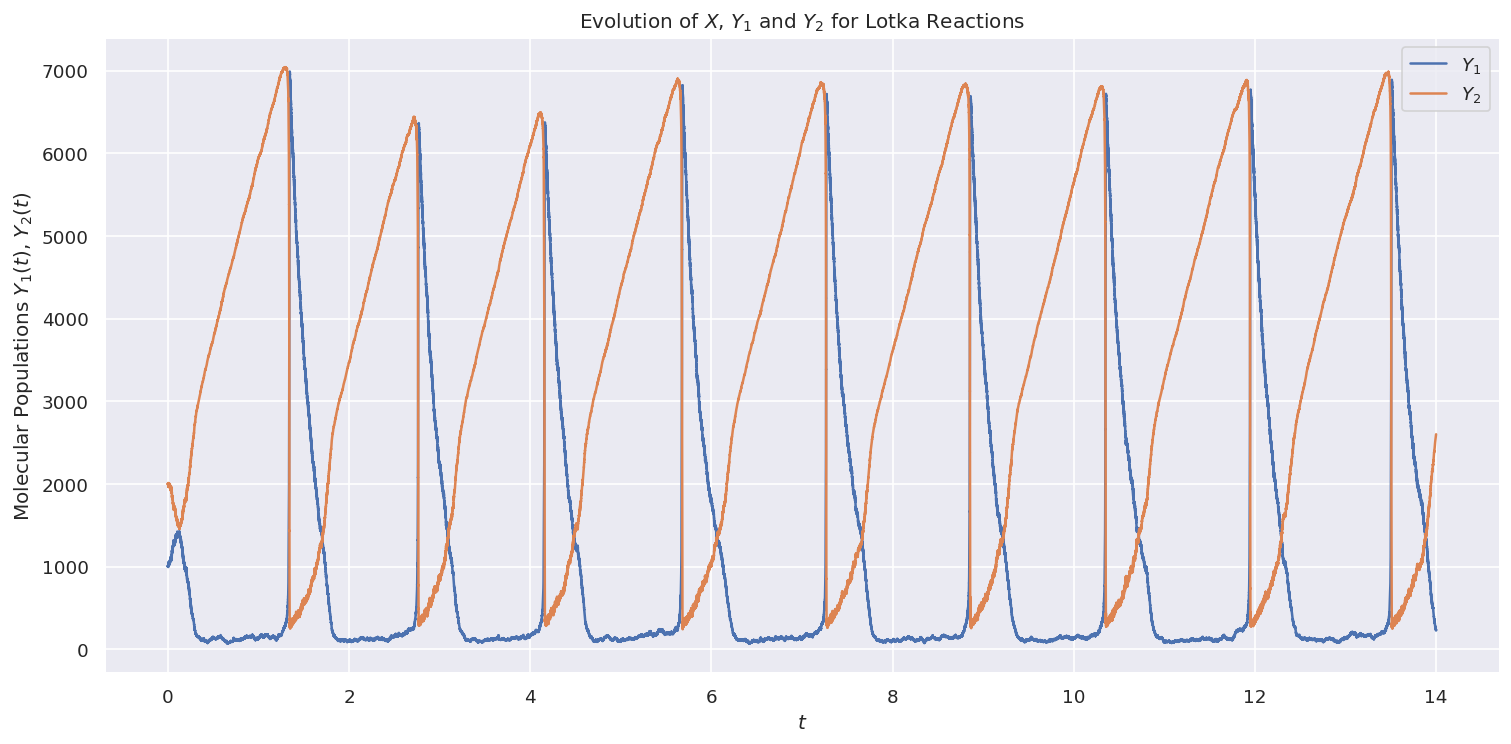

In [15]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(15,7))

ax.plot(t,x[:,0],label=r'$Y_{1}$ ')
ax.plot(t,x[:,1],label=r'$Y_{2}$')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Molecular Populations $Y_{1}(t)$, $Y_{2}(t)$')
ax.set_title(r'Evolution of $X$, $Y_{1}$ and $Y_{2}$ for Lotka Reactions')

ax.legend()

plt.show()

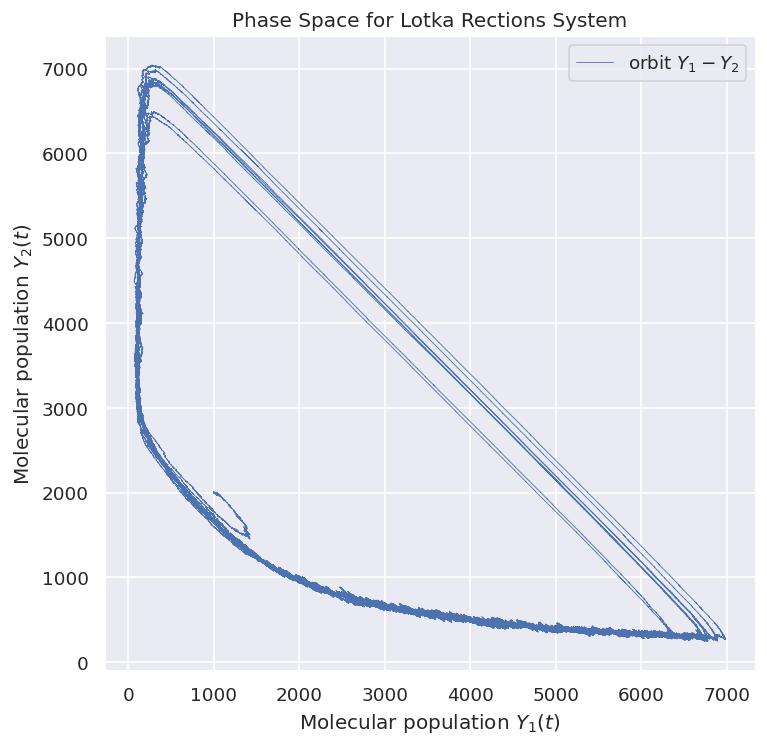

In [19]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(7,7))


ax.plot(x[:,0],x[:,1],label='orbit $Y_{1}-Y_{2}$',lw=0.5)

ax.set_xlabel(r'Molecular population $Y_{1}(t)$')
ax.set_ylabel(r'Molecular population $Y_{2}(t)$')
ax.set_title(r'Phase Space for Lotka Rections System')

#ax.set_ylim(0,5000)
#ax.set_xlim(0,5000)

ax.legend()

plt.show()

For this run time evolves in $0\le t<14$ and we achive $1,534,577$ reactions. In this time interval we are able to visualize that practically after $t\approx 1$ the system actually got to the limit cycle and it is _strong_ enough to dictate the dynamics once there _without matter on the stochastic fluctuations_ -in the phase portrait is easy to see that actually we do have variations and the system don't get to a limit cycle in the RRE sense but in the $Y_{i},t$-plots also we can observe that evolution of populations are very stable compared to those obtained in previous systems simulations. 

Now, lets reproduce it again but with a $t_{max}=18$ (same seed)

In [7]:
x,t = SSA(x=np.asarray([[1000,2000]]),t=[0],a=a,v=v,t_max=18)

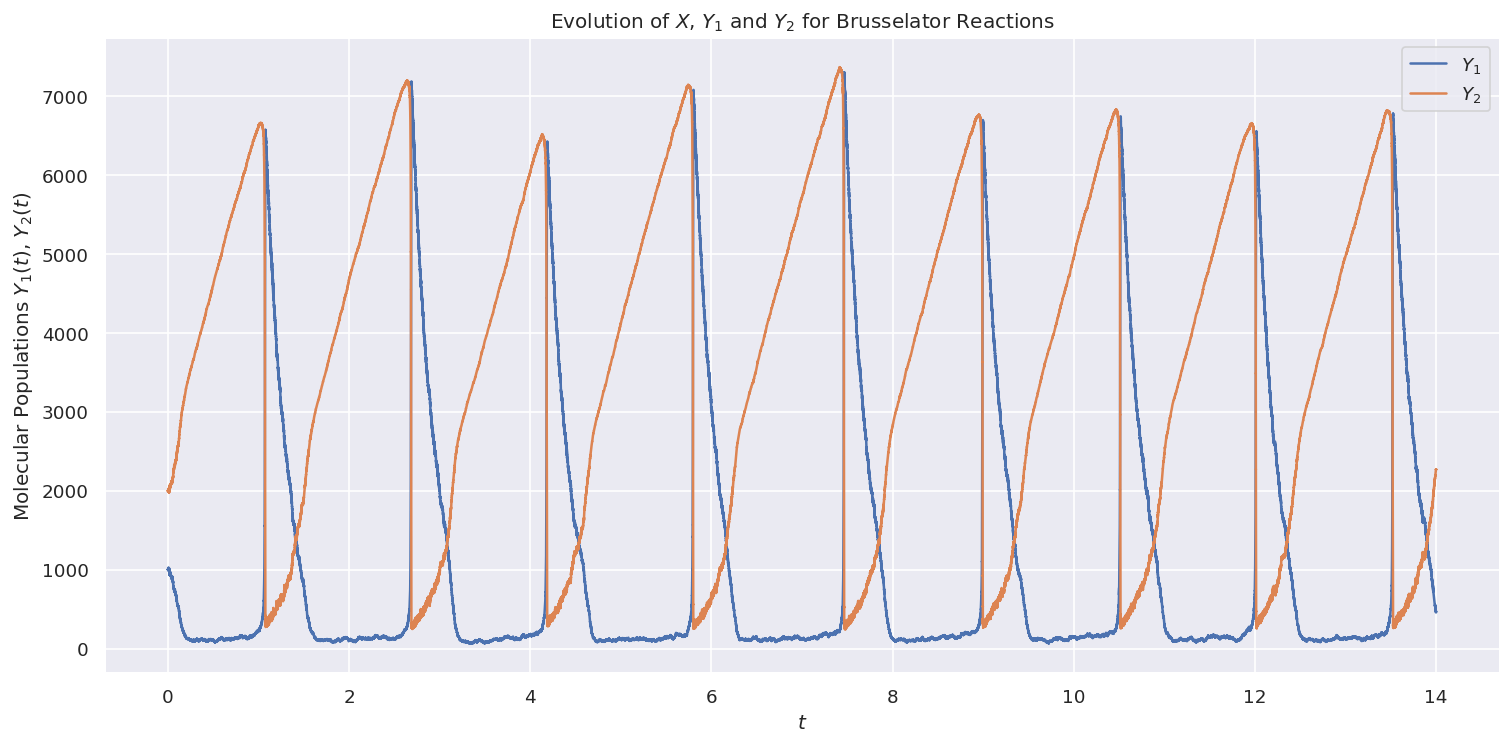

In [8]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(15,7))

ax.plot(t,x[:,0],label=r'$Y_{1}$ ')
ax.plot(t,x[:,1],label=r'$Y_{2}$')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Molecular Populations $Y_{1}(t)$, $Y_{2}(t)$')
ax.set_title(r'Evolution of $X$, $Y_{1}$ and $Y_{2}$ for Brusselator Reactions')

ax.legend()

plt.show()

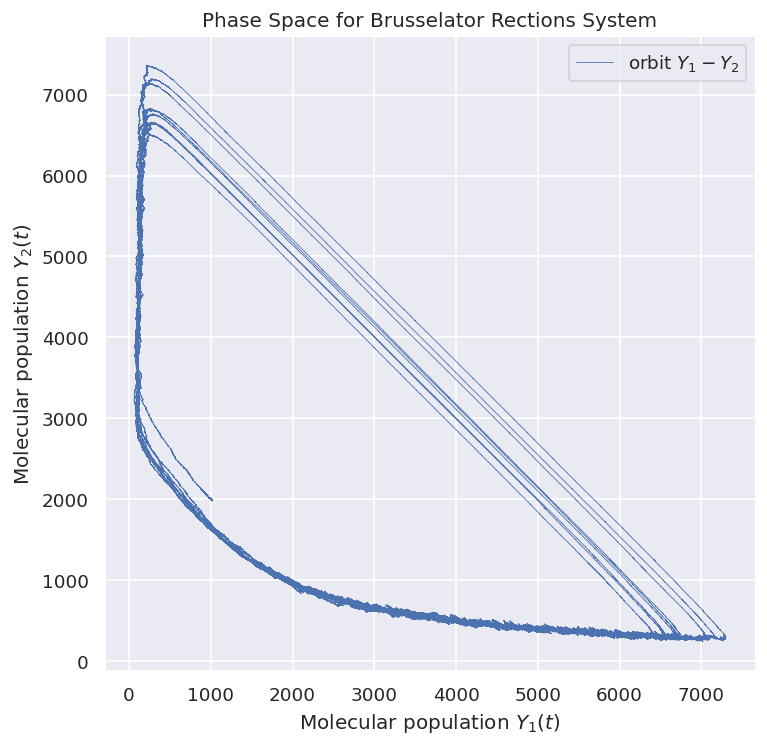

In [9]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(7,7))


ax.plot(x[:,0],x[:,1],label='orbit $Y_{1}-Y_{2}$',lw=0.5)

ax.set_xlabel(r'Molecular population $Y_{1}(t)$')
ax.set_ylabel(r'Molecular population $Y_{2}(t)$')
ax.set_title(r'Phase Space for Brusselator Rections System')

#ax.set_ylim(0,5000)
#ax.set_xlim(0,5000)

ax.legend()

plt.show()

For last run time evolved from $0\le t<18$ and we achived $1,537,559$ reactions. Clearly the system dynamics and the specifically the limit cycle si very strong as one can observe in the diagonal lines of phase protraite. 

Now lets us consider modification in Brusselator model, a natuarly decay of $X_{1}$ molecular population:
$$
\begin{eqnarray}
&X_{1} & \xrightarrow{\;\; C_{1} \;\; } Y_{1} \\
&\bar{X}_{2} + Y_{1}& \xrightarrow{\;\; C_{2} \;\; } Y_{2} + Z_{1} \\
&2Y_{1}+Y_{2}& \xrightarrow{\;\; C_{3} \;\; } 3 Y_{1} \\
&Y_{1}& \xrightarrow{\;\; C_{4} \;\; } Z \\
\end{eqnarray}
$$

The new set of propensity equations is as follows::
$$
\begin{eqnarray}
a_{1}(\mathbf{Y}) &=& c_1 [X_{1}] \\
a_{2}(\mathbf{Y}) &=& c_2 [\bar{X}_{2}][Y_{1}] = k_{2}[Y_{1}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{2}][Y_{1}]\displaystyle\frac{([Y_{1}]-1)}{2} \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{1}]
\end{eqnarray}
$$
And the new asociated state-change vectors are:
$$
\begin{eqnarray}
\nu_{1} &=& [-1,1,0] \\
\nu_{2} &=& [0,-1,1] \\
\nu_{3} &=& [0,1,-1] \\
\nu_{4} &=& [0,-1,0]
\end{eqnarray}
$$

To reproduce results we're going to use $c_{1}= 0.05$, $k_{2}=50$, $c_{3}=0.00005$ and $c_{4}=5$ with initial condition $\mathbf{Y_{0}}=[1\times10^{5},1000,2000]$

In [13]:
def R(Y,c1,k2,c3,c4):
    return np.asarray([c1*Y[0],k2*Y[1],c3*Y[2]*Y[1]*0.5*(Y[1]-1),c4*Y[1]])

In [14]:
a = lambda y : R(y,c1=0.05,k2=50,c3=0.00005,c4=5)
v = np.asarray([
    [-1,1,0],
    [0,-1,1],
    [0,1,-1],
    [0,-1,0]
])

In [15]:
x,t = SSA(x=np.asarray([[1e5,1000,2000]]),t=[0],a=a,v=v,t_max=40)

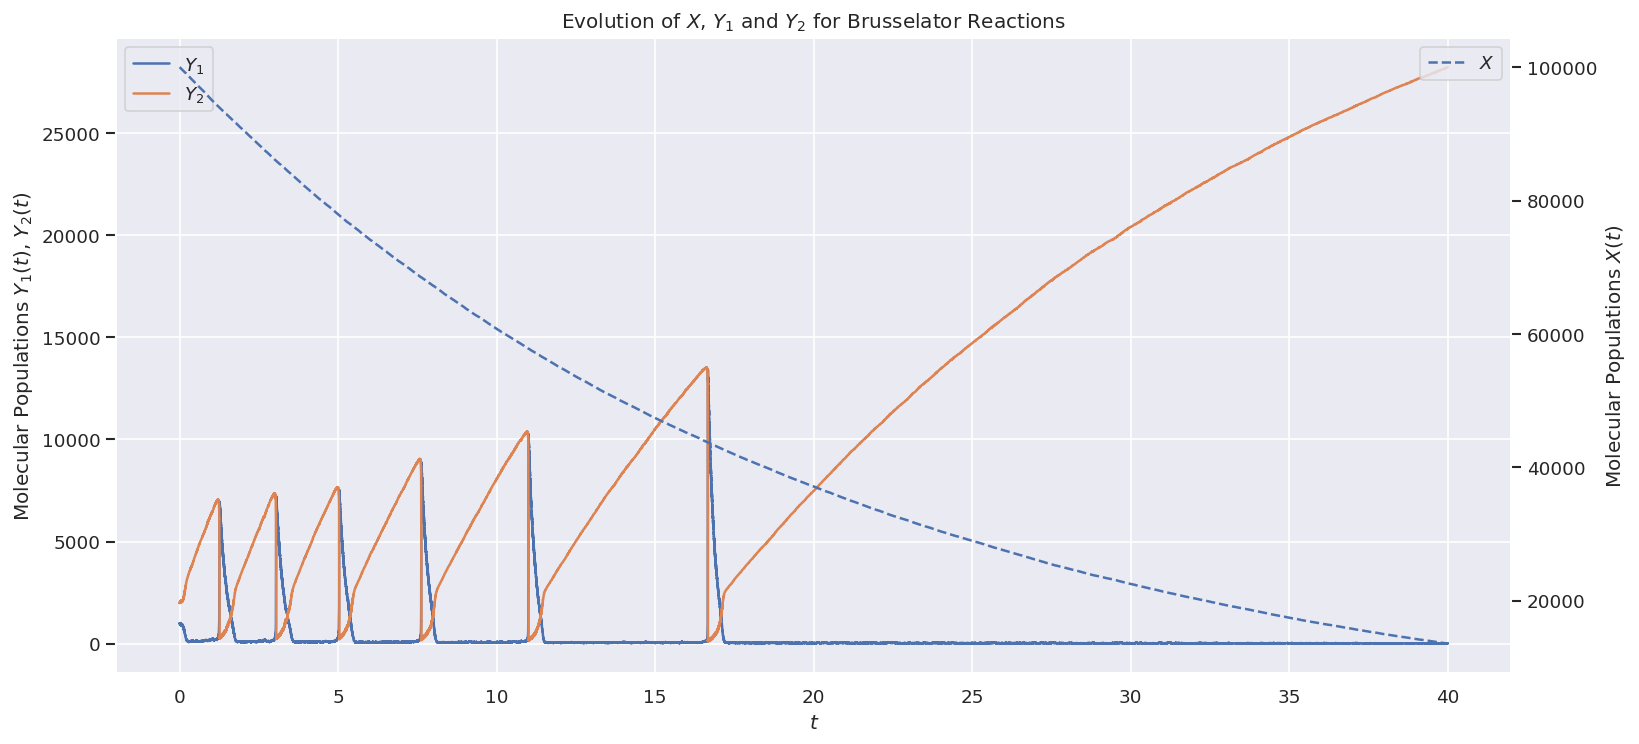

In [16]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(15,7))

ax.plot(t,x[:,1],label=r'$Y_{1}$ ')
ax.plot(t,x[:,2],label=r'$Y_{2}$')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Molecular Populations $Y_{1}(t)$, $Y_{2}(t)$')
ax.set_title(r'Evolution of $X$, $Y_{1}$ and $Y_{2}$ for Brusselator Reactions')

ax1 = ax.twinx()
ax1.plot(t,x[:,0],label=r'$X$',ls='--')
ax1.set_ylabel(r'Molecular Populations $X(t)$')

ax.legend()
ax1.legend()

ax1.grid(False)
plt.show()

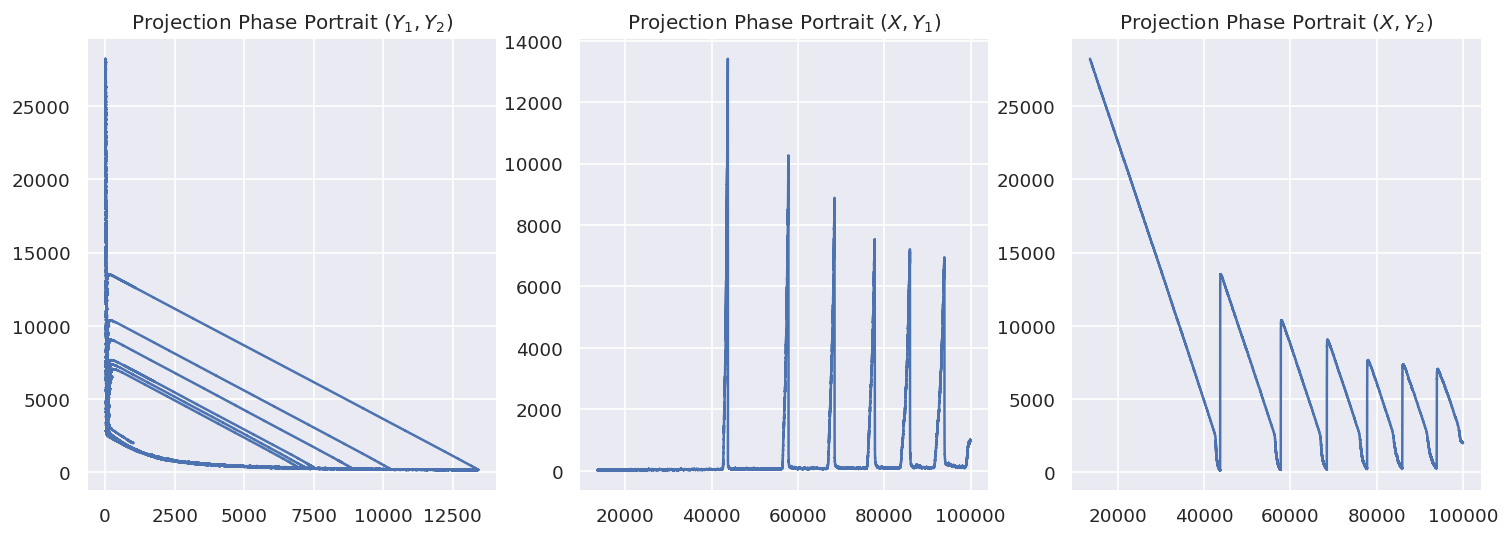

In [19]:
fig,ax = plt.subplots(1,3,dpi=120,figsize=(15,5))

ax[0].plot(x[:,1],x[:,2])
#ax[0].set_ylim(-100,1500)
#ax[0].set_xlim(0,3500)
ax[0].set_title(r'Projection Phase Portrait $(Y_{1},Y_{2})$')

ax[1].plot(x[:,0],x[:,1])
ax[1].set_title(r'Projection Phase Portrait $(X,Y_{1})$')


ax[2].plot(x[:,0],x[:,2])
ax[2].set_title(r'Projection Phase Portrait $(X,Y_{2})$')

plt.show()

In this last run the time ran over the interval $0\le t < 40$ and we got $1,347,059$. The dynamics changed because we close the system for $X_{1}$ therewfore the lost of the stable limit cycle. 

Now lets us consider a modification in Brusselator model, $X_{2}$ will become closed and $\bar{X}_{1}$ will return to be open:
$$
\begin{eqnarray}
&\bar{X}_{1} & \xrightarrow{\;\; C_{1} \;\; } Y_{1} \\
&X_{2} + Y_{1}& \xrightarrow{\;\; C_{2} \;\; } Y_{2} + Z_{1} \\
&2Y_{1}+Y_{2}& \xrightarrow{\;\; C_{3} \;\; } 3 Y_{1} \\
&Y_{1}& \xrightarrow{\;\; C_{4} \;\; } Z \\
\end{eqnarray}
$$

The new set of propensity equations is as follows::
$$
\begin{eqnarray}
a_{1}(\mathbf{Y}) &=& c_1 [\bar{X}_{1}] = k_{1} \\
a_{2}(\mathbf{Y}) &=& c_2 [X_{2}][Y_{1}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{2}][Y_{1}]\displaystyle\frac{([Y_{1}]-1)}{2} \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{1}]
\end{eqnarray}
$$
And the new asociated state-change vectors are:
$$
\begin{eqnarray}
\nu_{1} &=& [0,1,0] \\
\nu_{2} &=& [-1,-1,1] \\
\nu_{3} &=& [0,1,-1] \\
\nu_{4} &=& [0,-1,0]
\end{eqnarray}
$$

To reproduce results we're going to use $k_{1}= 5000$, $c_{2}=0.0005$, $c_{3}=0.00005$ and $c_{4}=5$ with initial condition $\mathbf{Y_{0}}=[1\times10^{5},1000,2000]$

In [6]:
def R(Y,k1,c2,c3,c4):
    return np.asarray([k1,
                       c2*Y[0]*Y[1],
                       c3*Y[2]*Y[1]*0.5*(Y[1]-1),
                       c4*Y[1]])

In [7]:
a = lambda y : R(y,k1=5000,c2=0.0005,c3=0.00005,c4=5)
v = np.asarray([
    [0,1,0],
    [-1,-1,1],
    [0,1,-1],
    [0,-1,0]
])

In [8]:
x,t = SSA(x=np.asarray([[1e5,1000,2000]]),t=[0],a=a,v=v,t_max=40)

In [9]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(15,7))

ax.plot(t,x[:,1],label=r'$Y_{1}$ ')
ax.plot(t,x[:,2],label=r'$Y_{2}$')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Molecular Populations $Y_{1}(t)$, $Y_{2}(t)$')
ax.set_title(r'Evolution of $X$, $Y_{1}$ and $Y_{2}$ for Brusselator Reactions')

ax1 = ax.twinx()
ax1.plot(t,x[:,0],label=r'$X_{2}$',ls='--')
ax1.set_ylabel(r'Molecular Populations $X_{2}(t)$')

ax.legend()
ax1.legend()

ax1.grid(False)
plt.show()

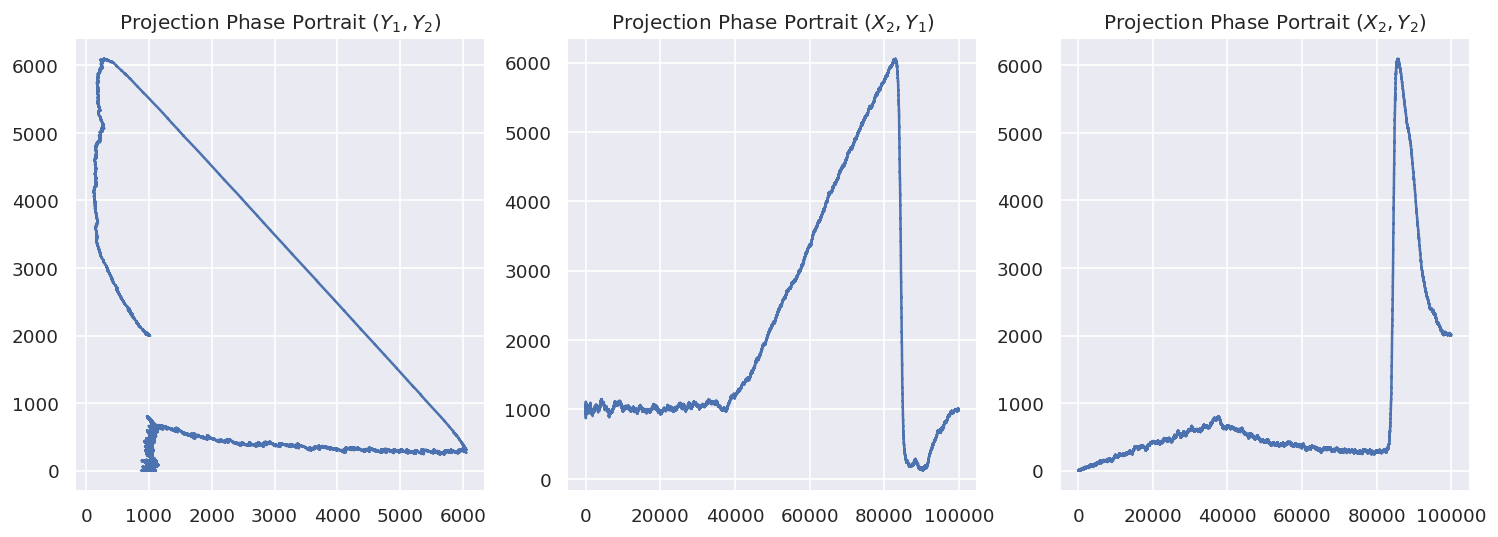

In [12]:
fig,ax = plt.subplots(1,3,dpi=120,figsize=(15,5))

ax[0].plot(x[:,1],x[:,2])
#ax[0].set_ylim(-100,1500)
#ax[0].set_xlim(0,3500)
ax[0].set_title(r'Projection Phase Portrait $(Y_{1},Y_{2})$')

ax[1].plot(x[:,0],x[:,1])
ax[1].set_title(r'Projection Phase Portrait $(X_{2},Y_{1})$')


ax[2].plot(x[:,0],x[:,2])
ax[2].set_title(r'Projection Phase Portrait $(X_{2},Y_{2})$')

plt.show()

The two las example exhibit how dependent are the oscilations in Brusselator to moleuclar populations $X_{i}$ be open. 

## 2.5 The Oregonator (cfr. [2])

Now lets us consider a modification _The Oregonator_ model:
$$
\begin{eqnarray}
&  \bar{X}_{1} + Y_{2}& \xrightarrow{\;\; C_{1} \;\; } Y_{1} \\
&Y_{1}+Y_{2}& \xrightarrow{\;\; C_{2} \;\; } Z_{1} \\
&\bar{X}_{2}+Y_{1}& \xrightarrow{\;\; C_{3} \;\; } 2 Y_{1}+Y_{3} \\
&2Y_{1}& \xrightarrow{\;\; C_{4} \;\; } Z \\
&\bar{X}_{3}+Y_{3}& \xrightarrow{\;\; C_{5} \;\; } Y_{2} \\
\end{eqnarray}
$$

The set of propensity equations is as follows::
$$
\begin{eqnarray}
a_{1}(\mathbf{Y}) &=& c_1 [\bar{X}_{1}][Y_{2}] \\
a_{2}(\mathbf{Y}) &=& c_2 [Y_{2}][Y_{1}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{1}][\bar{X}_{2}] \\
a_{4}(\mathbf{Y}) &=& c_4 \displaystyle\frac{1}{2}[Y_{1}]([Y_{1}]-1) \\
a_{5}(\mathbf{Y}) &=& c_5 [Y_{3}][\bar{X}_{3}]
\end{eqnarray}
$$
And the new asociated state-change vectors are:
$$
\begin{eqnarray}
\nu_{1} &=& [1,-1,0] \\
\nu_{2} &=& [-1,-1,0] \\
\nu_{3} &=& [1,0,1] \\
\nu_{4} &=& [-2,0,0] \\
\nu_{5} &=& [0,1,-1]
\end{eqnarray}
$$

If we consider now the first two ecuations of chemical model in a steady-state then we can define the steady-state ratios:
$$
\begin{eqnarray}
\bar{ \rho}_{1} = c_{1}[\bar{X}_{1}][\bar{Y}_{2}]\\
\bar{ \rho}_{2} = c_{2}[\bar{Y}_{1}][\bar{Y}_{2}]
\end{eqnarray}
$$

Where $\bar{Y}_{i}$ represents a steady-state value of the system. Futhermore, if we consider the RRE set and $Y'_{1}=Y'_{2}=Y'_{3}=0$ then we can reparametrize the model as follows:
$$
\begin{eqnarray}
&c_{1}[\bar{X}_{1}]& = \displaystyle\frac{\bar{\rho}_{1}}{[\bar{Y}_{2}]}\\
&c_{2}& = \displaystyle\frac{\bar{\rho}_{2} }{[\bar{Y}_{1}][\bar{Y}_{2}]}\\
&c_{3}[\bar{X}_{2}] & = \displaystyle\frac{\bar{\rho}_{1}+\bar{\rho}_{2}}{[\bar{Y}_{1}]}\\
&c_{4}& = \displaystyle\frac{2\bar{\rho}_{1}}{[\bar{Y}_{1}]^{2}} \\
&c_{5}[\bar{X}_{3}]& = \displaystyle\frac{\bar{\rho}_{1}+\bar{\rho}_{2}}{[\bar{Y}_{3}]}
\end{eqnarray}
$$

Hence we get a new set of propensity equations:
$$
\begin{eqnarray}
a_{1}(\mathbf{Y}) &=&\bar{\rho}_{1}\displaystyle\frac{[Y_{2}]}{[\bar{Y}_{2}]} \\
a_{2}(\mathbf{Y}) &=& \bar{\rho}_{2} \displaystyle\frac{[Y_{2}][Y_{1}]}{[\bar{Y}_{1}][\bar{Y}_{2}]}\\
a_{3}(\mathbf{Y}) &=& (\bar{\rho}_{1}+\bar{\rho}_{2})\displaystyle\frac{[Y_{1}]}{[\bar{Y}_{1}]} \\
a_{4}(\mathbf{Y}) &=& \bar{\rho}_{1} \displaystyle\frac{[Y_{1}]([Y_{1}]-1)}{[\bar{Y}_{1}]^{2}} \\
a_{5}(\mathbf{Y}) &=& (\bar{\rho}_{1}+\bar{\rho}_{2})\displaystyle\frac{[Y_{3}]}{[\bar{Y}_{3}]}
\end{eqnarray}
$$

The first simulations will get $[\bar{Y}_{1}]=500$, $[\bar{Y}_{2}]=1000$, $[\bar{Y}_{3}]=2000$, $\bar{\rho}_{1}=2000$, $\bar{\rho}_{1}=50000$ with a $\mathbf{Y}_{0}=[500,1000,2000]$

In [10]:
def R(Y,r1=2000,r2=50000,ys1=500,ys2=1000,ys3=2000):
    return np.asarray([(r1/ys2)*Y[1],
                       (r2/(ys1*ys2))*Y[0]*Y[1],
                       ((r1+r2)/ys1)*Y[0],
                       (r1 / ys1**2)*Y[0]*(Y[0]-1),
                       ((r1+r2)/ys3)*Y[2]])

In [12]:
#a = lambda y : R(y,r1=2000,r2=50000,ys1=500,ys2=1000,ys3=2000)
v = np.asarray([
    [1,-1,0],
    [-1,-1,0],
    [1,0,1],
    [-2,0,0],
    [0,1,-1]
])

In [13]:
x,t = SSA(x=np.asarray([[500,1000,2000]]),t=[0],a=R,v=v,t_max=10)

In [14]:
fig,ax = plt.subplots(1,1,dpi=120,figsize=(15,7))

ax.plot(t,x[:,0],label=r'$Y_{1}$')
ax.plot(t,x[:,1],label=r'$Y_{2}$ ')
ax.plot(t,x[:,2],label=r'$Y_{3}$')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Molecular Populations $Y_{1}(t)$, $Y_{2}(t)$, $Y_{3}(t)$')
ax.set_title(r'Evolution of $Y_{1}$, $Y_{2}$ and $Y_{3}$ for Oregonator Reactions')

ax.legend()

plt.show()

Let us notice that the system get automatically in the steady-state (intended by construction) and the fluctiations are negligible. 

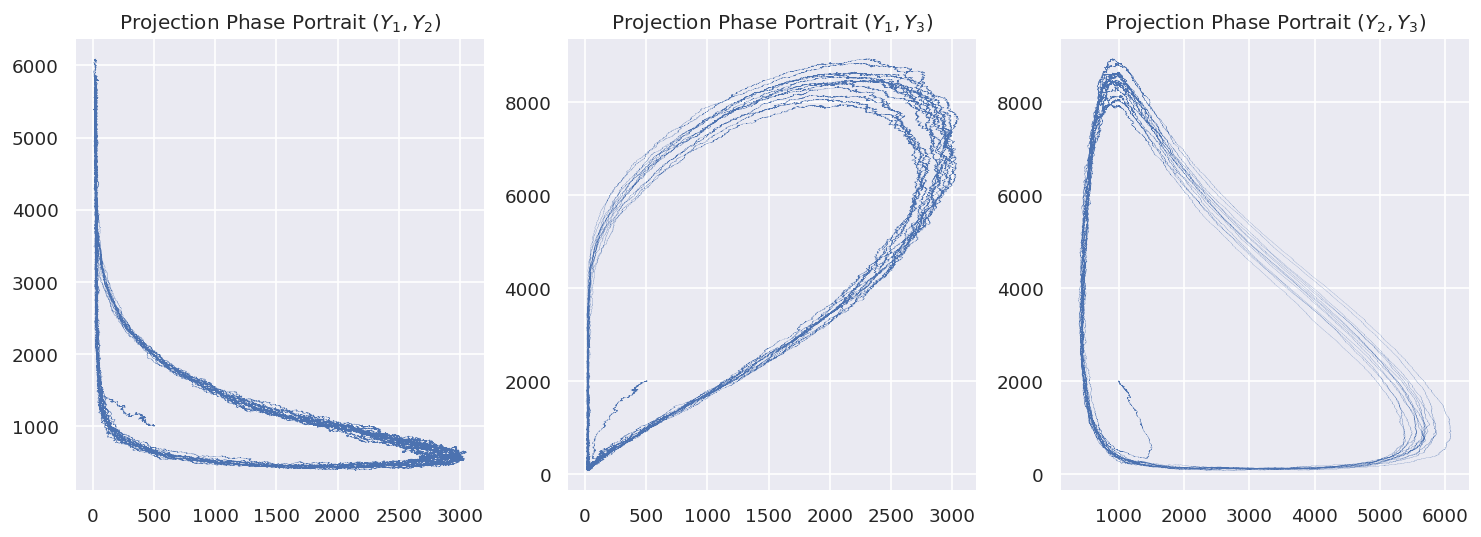

In [99]:
fig,ax = plt.subplots(1,3,dpi=120,figsize=(15,5))

ax[0].plot(x[:,0],x[:,1],lw=0.1)
#ax[0].set_ylim(-100,1500)
#ax[0].set_xlim(0,3500)
ax[0].set_title(r'Projection Phase Portrait $(Y_{1},Y_{2})$')

ax[1].plot(x[:,0],x[:,2],lw=0.1)
ax[1].set_title(r'Projection Phase Portrait $(Y_{1},Y_{3})$')


ax[2].plot(x[:,1],x[:,2],lw=0.1)
ax[2].set_title(r'Projection Phase Portrait $(Y_{2},Y_{3})$')

plt.show()

In [97]:
#fig = plt.figure(dpi=120,figsize=(9,9))
#ax = fig.gca(projection='3d')
fig, ax = plt.subplots(1, 3, figsize=(26, 8), subplot_kw={'projection': '3d'},dpi=120)

ax[0].scatter(xs=500,ys=1000,zs=2000,s=40,color='red',label=r'$\mathbf{Y_{0}}$')
ax[0].plot(xs=x[:,0], ys=x[:,1], zs=x[:,2], zdir='z',lw=0.1)
ax[0].set_xlabel(r'$Y_{1}$')
ax[0].set_ylabel(r'$Y_{2}$')
ax[0].set_zlabel(r'$Y_{3}$')

ax[0].view_init(elev=20., azim=-45)
ax[0].legend()


ax[1].scatter(xs=500,ys=1000,zs=2000,s=40,color='red',label=r'$\mathbf{Y_{0}}$')
ax[1].plot(xs=x[:,0], ys=x[:,1], zs=x[:,2], zdir='z',lw=0.1)
ax[1].set_xlabel(r'$Y_{1}$')
ax[1].set_ylabel(r'$Y_{2}$')
ax[1].set_zlabel(r'$Y_{3}$')

ax[1].view_init(elev=15., azim=145)
ax[1].legend()


ax[2].scatter(xs=500,ys=1000,zs=2000,s=40,color='red',label=r'$\mathbf{Y_{0}}$')
ax[2].plot(xs=x[:,0], ys=x[:,1], zs=x[:,2], zdir='z',lw=0.1)
ax[2].set_xlabel(r'$Y_{1}$')
ax[2].set_ylabel(r'$Y_{2}$')
ax[2].set_zlabel(r'$Y_{3}$')

ax[2].view_init(elev=0., azim=45)
ax[2].legend()

fig.suptitle(r'Oregonator phase space',y=1.01,fontsize=20)
fig.tight_layout()

plt.show()

For this late run we achived $1,161,743$ reactions over the time interval $0\le t < 10$.

An interesting experiment is to consider the system closed for molecular populations $X_{1}$, $X_{2}$ and $X_{3}$. 

# References

[1] Gillespie, D. (2007). Stochastic Simulation of Chemical Kinetics. Annual Review Of Physical Chemistry, 58(1), 35-55. doi: 10.1146/annurev.physchem.58.032806.104637

[2] Gillespie, D. (1977). Exact stochastic simulation of coupled chemical reactions. The Journal Of Physical Chemistry, 81(25), 2340-2361. doi: 10.1021/j100540a008